In [198]:
%pip install keras-tuner --upgrade

In [199]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import manifold
from matplotlib import pyplot as plt
from matplotlib import animation  # animate 3D plots
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
import numpy as np
import pandas as pd
import seaborn as sns

In [200]:
dataset = pd.read_csv("products.csv")
dataset = dataset.sample(frac=1)
dataset_features = dataset.copy()
dataset_label = dataset_features.pop('MTTF')

In [201]:
features_max = dataset_features.max()
labels_max = dataset_label.max()
dataset_features /= features_max
dataset_label /= dataset_label.max()

In [202]:
inputs = {name:tf.keras.Input(shape=(1,), name=name, dtype=tf.float32) for name, _ in dataset_features.items()}
inputs

{'100kwh': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '100kwh')>,
 '75kwh': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '75kwh')>,
 'AS': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'AS')>,
 'Adjust_EM': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Adjust_EM')>,
 'Automatic_Locking': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Automatic_Locking')>,
 'Automatic_PW': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Automatic_PW')>,
 'BatterySystem': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'BatterySystem')>,
 'BodyComfortSystem': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'BodyComfortSystem')>,
 'CLS': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'CLS')>,
 'ChargingBehaviour': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ChargingBehaviour')>,
 'Clean': <KerasTensor: shape=(None, 1) dtype=float32 (created by la

In [203]:
numeric_inputs = {name: input_feature for name, input_feature in inputs.items() if input_feature.dtype == tf.float32}
numeric_inputs

{'100kwh': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '100kwh')>,
 '75kwh': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '75kwh')>,
 'AS': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'AS')>,
 'Adjust_EM': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Adjust_EM')>,
 'Automatic_Locking': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Automatic_Locking')>,
 'Automatic_PW': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Automatic_PW')>,
 'BatterySystem': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'BatterySystem')>,
 'BodyComfortSystem': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'BodyComfortSystem')>,
 'CLS': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'CLS')>,
 'ChargingBehaviour': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ChargingBehaviour')>,
 'Clean': <KerasTensor: shape=(None, 1) dtype=float32 (created by la

In [204]:
x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(dataset_features[numeric_inputs.keys()]))
# all_numeric_inputs = norm(x)
preprocessed_inputs = [x]

In [205]:
preprocessing_layer = tf.keras.Model(inputs, preprocessed_inputs, name="ProcessData")

In [206]:
preprocessing_layer.summary()

Model: "ProcessData"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 BodyComfortSystem (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 100kwh (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Clean_Protection (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 LED_Wiper (InputLayer)         [(None, 1)]          0           []                               
                                                                                        

In [207]:
items_features_dict = {name: np.array(value) for name, value in dataset_features.items()}

# grab two samples
two_sample_dict = {name:values[1:3, ] for name, values in items_features_dict.items()}
two_sample_dict

{'100kwh': array([1., 1.]),
 '75kwh': array([0., 0.]),
 'AS': array([1., 1.]),
 'Adjust_EM': array([1., 1.]),
 'Automatic_Locking': array([1., 0.]),
 'Automatic_PW': array([0., 1.]),
 'BatterySystem': array([1., 1.]),
 'BodyComfortSystem': array([1., 1.]),
 'CLS': array([1., 1.]),
 'ChargingBehaviour': array([1., 1.]),
 'Clean': array([1., 0.]),
 'Clean_Protection': array([0., 0.]),
 'Control_AS': array([1., 0.]),
 'Control_Automatic_PW': array([0., 0.]),
 'DoorSystem': array([1., 1.]),
 'EM': array([1., 1.]),
 'Electric': array([1., 1.]),
 'Electrical': array([1., 1.]),
 'ElectroMotor': array([1., 1.]),
 'FP': array([1., 1.]),
 'Fast': array([1., 1.]),
 'Frost_Protection': array([1., 1.]),
 'HMI': array([1., 1.]),
 'Heatable': array([1., 0.]),
 'High_Quality_Sensor': array([0., 1.]),
 'High_Quality_Wiper': array([1., 1.]),
 'Interior_Monitoring': array([0., 0.]),
 'LED_AS': array([1., 0.]),
 'LED_CLS': array([0., 1.]),
 'LED_Clean': array([0., 0.]),
 'LED_EM': array([0., 0.]),
 'LED_F

In [208]:
two_sample_fitted = preprocessing_layer(two_sample_dict)
two_sample_fitted


<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
        0., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
        1., 1.]], dtype=float32)>

In [209]:
full_dim = two_sample_fitted.shape.as_list()[1]

encoding_dim1 = 64
encoding_dim2 = 16
encoding_dim3 = 3
encoder_input_data = keras.Input(shape=(full_dim,))

# the encoded representation of the input
encoded_layer1 = keras.layers.Dense(encoding_dim1, activation='relu')(encoder_input_data)
encoded_layer2 = keras.layers.Dense(encoding_dim2, activation='relu')(encoded_layer1)
# Note that encoded_layer3 is our 3 dimensional "clustered" layer, which we will later use for clustering
encoder_output = keras.layers.Dense(encoding_dim3, activation='relu', name="ClusteringLayer")(encoded_layer2)

encoder = keras.Model(encoder_input_data, encoder_output, name="encoder")

encoder.summary()

decoder_input = keras.Input(shape=(encoding_dim3,))

decoded_layer3 = keras.layers.Dense(encoding_dim2, activation='relu')(decoder_input)
decoded_layer2 = keras.layers.Dense(encoding_dim1, activation='relu')(decoded_layer3)
decoder_output = keras.layers.Dense(full_dim, activation='sigmoid')(decoded_layer2)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(full_dim,))
encoded_input = encoder(autoencoder_input)
decoded_input = decoder(encoded_input)
autoencoder = keras.Model(autoencoder_input, decoded_input, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 50)]              0         
                                                                 
 dense_55 (Dense)            (None, 64)                3264      
                                                                 
 dense_56 (Dense)            (None, 16)                1040      
                                                                 
 ClusteringLayer (Dense)     (None, 3)                 51        
                                                                 
Total params: 4,355
Trainable params: 4,355
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 3)]

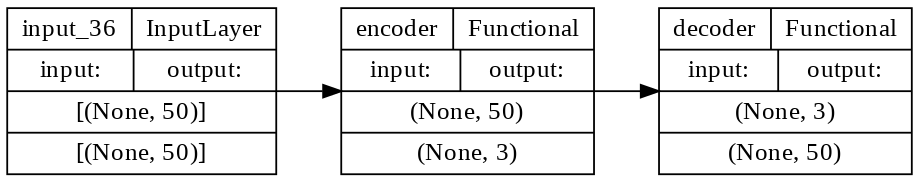

In [210]:
autoencoder.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3), loss=tf.keras.losses.mean_squared_error)
tf.keras.utils.plot_model(model=autoencoder, rankdir="LR", dpi=130, show_shapes=True, to_file="autoencoder.png")

In [211]:
items = preprocessing_layer(items_features_dict)

train_data, test_data, train_labels, test_labels = train_test_split(items.numpy(), dataset_label, train_size=0.6, random_state=5)
history = autoencoder.fit(train_data, train_data, epochs=200, batch_size=10, shuffle=True, validation_data=(test_data, test_data))

Epoch 1/200
6/6 [==============================] - 2s 53ms/step - loss: 0.2430 - val_loss: 0.2292
Epoch 2/200
6/6 [==============================] - 0s 15ms/step - loss: 0.2140 - val_loss: 0.2057
Epoch 3/200
6/6 [==============================] - 0s 14ms/step - loss: 0.1921 - val_loss: 0.1916
Epoch 4/200
6/6 [==============================] - 0s 15ms/step - loss: 0.1785 - val_loss: 0.1818
Epoch 5/200
6/6 [==============================] - 0s 11ms/step - loss: 0.1692 - val_loss: 0.1743
Epoch 6/200
6/6 [==============================] - 0s 12ms/step - loss: 0.1631 - val_loss: 0.1693
Epoch 7/200
6/6 [==============================] - 0s 14ms/step - loss: 0.1593 - val_loss: 0.1656
Epoch 8/200
6/6 [==============================] - 0s 38ms/step - loss: 0.1570 - val_loss: 0.1642
Epoch 9/200
6/6 [==============================] - 0s 14ms/step - loss: 0.1556 - val_loss: 0.1641
Epoch 10/200
6/6 [==============================] - 0s 15ms/step - loss: 0.1554 - val_loss: 0.1627
Epoch 11/200
6/6 [=

In [212]:
encoded_items = encoder(items)

In [213]:
encoded_items

<tf.Tensor: shape=(100, 3), dtype=float32, numpy=
array([[ 0.23284203, 13.870251  , 16.84169   ],
       [20.62312   , 10.981852  , 22.00775   ],
       [13.709734  ,  5.497952  , 25.19608   ],
       [11.815684  , 10.489922  ,  5.336488  ],
       [12.079522  , 12.024752  ,  0.        ],
       [ 9.490454  ,  8.88743   ,  0.86423343],
       [11.904981  ,  8.402878  , 17.343632  ],
       [14.728065  , 12.040237  ,  9.685639  ],
       [ 6.781178  ,  8.682758  , 11.262301  ],
       [19.104263  , 18.078323  ,  9.352322  ],
       [ 1.01955   ,  9.51945   , 13.505046  ],
       [ 4.5374427 ,  6.9852867 ,  3.9500134 ],
       [11.045092  , 10.674653  , 11.331651  ],
       [ 1.4566933 , 12.047381  , 10.062511  ],
       [11.054338  ,  7.9960785 , 20.789366  ],
       [ 1.1528894 ,  8.526875  , 19.614588  ],
       [18.22605   ,  5.760814  ,  7.4506764 ],
       [10.801747  ,  7.44005   , 12.030463  ],
       [ 9.361636  ,  0.        ,  5.671083  ],
       [12.469092  ,  4.6595216 ,  0. 

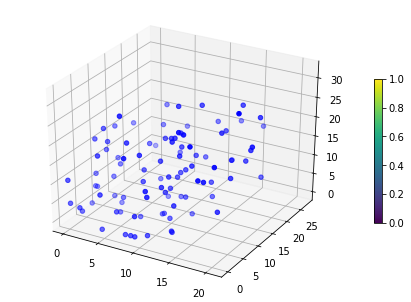

In [214]:
encoded_fig = plt.figure()
ax = Axes3D(encoded_fig)
p = ax.scatter(encoded_items[:,0], encoded_items[:,1], encoded_items[:,2], c="blue", marker="o", picker=True, cmap="rainbow")
plt.colorbar(p, shrink=0.5)
plt.show()

def rotate(angle):
    ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(encoded_fig, rotate, frames=np.arange(0, 360, angle), interval=50)

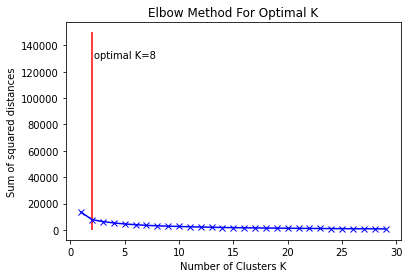

In [215]:
encoded_items = encoder(items)

# choose number of clusters K:
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(init='k-means++', n_clusters=k, n_init=10)
    km.fit(encoded_items)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.vlines(ymin=0, ymax=150000, x=2, colors='red')
plt.text(x=2.2, y=130000, s="optimal K=8")
plt.xlabel('Number of Clusters K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal K')
plt.show()

In [219]:
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(encoded_items)
P = kmeans.predict(encoded_items)

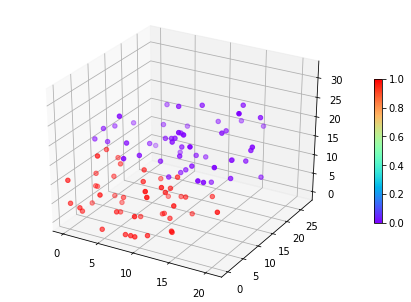

In [220]:
encoded_fig = plt.figure()
ax = Axes3D(encoded_fig)
p = ax.scatter(encoded_items[:,0], encoded_items[:,1], encoded_items[:,2], c=P, marker="o", picker=True, cmap="rainbow")
plt.colorbar(p, shrink=0.5)
plt.show()

angle = 3
ani = animation.FuncAnimation(encoded_fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('kmeans_fig.gif', writer=animation.PillowWriter(fps=12))

In [221]:
decoded_items = decoder(encoded_items)
decoded_items[0]

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([1.0000000e+00, 9.6446896e-01, 2.0096570e-05, 4.2880058e-02,
       6.1704540e-01, 1.0000000e+00, 9.2392087e-01, 1.0000000e+00,
       7.3603660e-02, 6.8148959e-01, 7.2684288e-03, 2.5625151e-01,
       1.0000000e+00, 9.9998736e-01, 2.9806775e-01, 1.0000000e+00,
       1.0000000e+00, 1.6829026e-06, 2.1221391e-05, 5.6772047e-01,
       1.0000000e+00, 8.9086151e-01, 1.0000000e+00, 8.3748317e-01,
       1.0000000e+00, 3.3734149e-01, 5.5851996e-01, 9.8781449e-01,
       2.1802849e-01, 9.1389126e-01, 1.0000000e+00, 1.0000000e+00,
       3.2976860e-01, 1.0000000e+00, 5.4522157e-03, 2.6495349e-01,
       6.7628145e-02, 4.5396030e-07, 7.2915286e-01, 2.2730556e-01,
       1.0000000e+00, 3.7465271e-01, 3.4013534e-01, 1.0000000e+00,
       3.0703452e-01, 9.9104899e-01, 7.8850341e-01, 1.0000000e+00,
       9.9564409e-01, 8.3772647e-01], dtype=float32)>

In [232]:
output = ""
for feature in decoded_items[0]:
    if feature >= 1:
        output += '"1",'
    else:
        output += '"0",'

In [233]:
output

'1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 '